In [1]:
import cvxpy as cvx
import numpy as np

# Subtask 1

In [2]:
import scipy.io as sio
mat_contents = sio.loadmat('task1.mat')
beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']

In [3]:
len(np.unique(beacons))

17

In [4]:
len(np.unique(robots))

28

First, let's formulate task as a linear least squares problem. We have fixed position's of $17$ beacons and $28$ robot positions. We also know connection between them:
$$ x^r_i + \Delta x_{ij} \simeq x^b_j, \\
x^r_i + \Delta x_{ij} = x^b_j + \delta x^{noise}_j
$$
To formulate least squares problem, we should re-write it as following:
$$
-x^r_i + x^b_j \simeq \Delta x_{ij} 
$$
And then add all $\{x^r_i, x^b_j\}$ and $\{y^r_i, y^b_j\}$ to $x$ of least squares problem, $\Delta x_{ij}$ and $\Delta y_{ij}$ to $b$, and substractions $-x^r_i + x^b_j$,$-y^r_i + y^b_j$ to matrix $A$.
$$
A x = b,\\
x := \{x^r,x^b,y^r,y^b\},\\
b := \{\Delta x, \Delta y\}
$$

In [5]:
N = len(np.unique(beacons)) + len(np.unique(robots)) 
# 2*N - total number of x in lstsq problem (N - number of x, N - number of y)

In [6]:
A = np.zeros((len(x)+1,N)) #+1 to add constraint about fixing first point

In [7]:
line = 0
for _i,_j in zip(robots,beacons):
    i = _i[0] - 1
    j = _j[0] - 1 + len(np.unique(robots))
    A[line][i] = -1 # for x
    A[line][j] = 1  # for x
    line += 1
A[-1][0] = 1 #to fix first point at (0,0)

In [8]:
xr,_,_,_ = np.linalg.lstsq(A,np.append(x,0)) #and append again to fix first point
yr,_,_,_ = np.linalg.lstsq(A,np.append(y,0))

In [9]:
beacon_poses = [b for b in zip(xr,yr)][-len(np.unique(beacons)):]
robot_poses = [b for b in zip(xr,yr)][:len(np.unique(robots))]
#in this arrays (x,y) coordinates of each beacon and robot position

In [10]:
# here I packed calculations with correct north orientation to get soon initial state for subtask 2
def correct_compass(beacons, robots, x,y):
    N = len(np.unique(beacons)) + len(np.unique(robots)) 
    A = np.zeros((len(x)+1,N))
    line = 0
    for _i,_j in zip(robots,beacons):
        i = _i[0] - 1
        j = _j[0] - 1 + len(np.unique(robots))
        A[line][i] = -1 # for x
        A[line][j] = 1  # for x
        line += 1
    A[-1][0] = 1
    xr,_,_,_ = np.linalg.lstsq(A,np.append(x,0)) #and append again to fix first point
    yr,_,_,_ = np.linalg.lstsq(A,np.append(y,0))
    return xr,yr

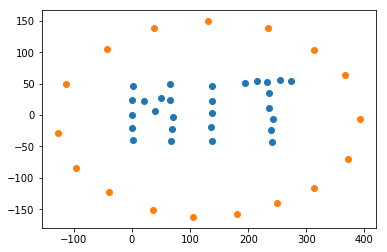

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(xr[:len(np.unique(robots))],yr[:len(np.unique(robots))])
plt.scatter(xr[-len(np.unique(beacons)):],yr[-len(np.unique(beacons)):])
plt.show()

# Subtask 2

In [177]:
mat_contents = sio.loadmat('task2.mat')
beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']
print(beacons.shape,robots.shape,x.shape,y.shape)

(350, 1) (350, 1) (350, 1) (350, 1)


Now we have problems with compass and actually what we measure is not $\Delta x_{ij}$, but $\cos \alpha_i \Delta x_{ij}  -\sin \alpha_i \Delta y_{ij}$. Better in matrix form: 
$$
    R\left(\alpha_i\right)
    \begin{bmatrix}
    \Delta x^{real}_{ij}  \\
    \Delta y^{real}_{ij} 
    \end{bmatrix}
   = 
    \begin{bmatrix}
    \Delta x_{ij}  \\
    \Delta y_{ij} 
    \end{bmatrix},\\
    R\left(\alpha_i\right) = \begin{bmatrix}
    \cos \alpha_i & - \sin \alpha_i \\
    \sin \alpha_i & \cos \alpha_i
    \end{bmatrix}
$$



This introduce non-linearity on $\alpha_i$. Each measurement gives us
$$
f_{ij}\left(\vec{x}^{\,r}_i,\vec{x}^{\,b}_j,\alpha_i\right) =  \vec{x}^{\,b}_j - \vec{x}^{\,r}_i - R\left(\alpha_i\right) \Delta \vec{x}_{ij} 
$$
We have to minimize
$$\sum_{ij} \left| \left| f_{ij}\left( \vec{x}^{\,r}_i,\vec{x}^{\,b}_j,\alpha_i \right) \right| \right|_2$$

To use scipy.optimize module (and scipy.optimize.least_squares) we need to provide $F(x)$ which returns $m$-dimensional residual. Again, $x := \{ x^r, y^r, \alpha, x^b, y^b \}$

In [178]:
from scipy.optimize import least_squares 

In [179]:
#as we need to pack all variables into big x array for solver, let's define lens of subparts:
len_xr = len(np.unique(robots))
len_yr = len_xr
len_ar = len_xr
len_xb = len(np.unique(beacons))
len_yb = len_xb
#this index arrays will be used to quick access for F function
robots_index = (robots-1).flatten()
beacons_index = (beacons-1).flatten()
x = x.flatten()
y = y.flatten()
#unpackX function - for calculations it's more visible and readable
def unpackX(X):
    ar = X[len_xr+len_yr:len_xr+len_yr+len_ar] 
    xr = X[:len_xr]
    yr = X[len_xr:len_xr +len_yr]
    xb = X[-len_xb-len_yb:-len_yb]
    yb = X[-len_yb:]
    return xr,yr,ar,xb,yb
#main (len(x)*2 + 1*2 <- len(np.unique(x^r))*3 + len(np.unique(x^b))*2) residual calculating function
def F(X):
    #unpack X
    xr,yr,ar,xb,yb = unpackX(X)
    cos_a = np.cos(ar)
    sin_a = np.sin(ar)
    #calculate residuals
    xdiff = xb[beacons_index] - xr[robots_index] - cos_a[robots_index]*x + sin_a[robots_index]*y
    ydiff = yb[beacons_index] - yr[robots_index] - sin_a[robots_index]*x - cos_a[robots_index]*y
    #print((np.concatenate((xdiff,ydiff))).flatten().shape)
    
    # fix first point at (0,0)
    xdiff = np.append(xdiff,xr[0]) 
    ydiff = np.append(ydiff,yr[0])
    return np.append(np.concatenate((xdiff,ydiff)),ar[0]).flatten()

In [180]:
#use inital state for x from assumption that we have correct angles (α_i=0)
xr_init,yr_init = correct_compass(beacons,robots,x,y)
x_init = np.concatenate((xr_init[:len_xr],yr_init[:len_yr],np.zeros((len_ar)),xr_init[len_xr:],yr_init[len_yr:]))

In [16]:
%%time
#use scipy.optimize.least_squares to calculate result
result = least_squares(F,x_init,method='lm')

CPU times: user 620 ms, sys: 216 ms, total: 836 ms
Wall time: 581 ms


In [17]:
xr,yr,ar,xb,yb = unpackX(result['x'])

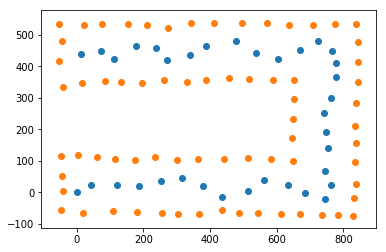

In [18]:
plt.scatter(xr,yr)
plt.scatter(xb,yb)
plt.show()

Also we are asked to prepare $jac(x)$ function. $$jac(\vec{x}) = \frac{\partial F_k}{\partial x_i}$$
For $x^r,y^r,x^b,y^b$ partial derivatives will be either $1$,$0$ or $-1$.

In [229]:
def jac(X):
    xr,yr,ar,xb,yb = unpackX(X)
    sin_a = np.sin(ar)
    cos_a = np.cos(ar)
    J = np.zeros((x.shape[0]*2+3,X.shape[0]))
    #first part is for xdiff
    x_range = list(range(x.shape[0]))
    J[x_range,robots_index] = -1 #x^r
    J[x_range,beacons_index+len_xr+len_yr+len_ar] = 1 #x^b
    J[x_range,robots_index+len_xr+len_yr] = sin_a[robots_index]*x + cos_a[robots_index]*y #a^r
    J[x.shape[0],0] = 1
    #second is for ydiff
    y_range = list(range(x.shape[0]+1,x.shape[0]*2+1))
    J[y_range,robots_index+len_xr] = -1 #y^r
    J[y_range,beacons_index+len_xr+len_yr+len_ar+len_xb] = 1 #y^b
    J[y_range,robots_index+len_xr+len_yr] = - cos_a[robots_index]*x + sin_a[robots_index]*y
    J[-2,len_xr] = 1
    J[-1,len_xr+len_yr] = 1
    #print(beacons_index+len_xr+len_yr+len_ar+len_xb)
    return J


In [20]:
%%time
#use scipy.optimize.least_squares to calculate result
result = least_squares(F,x_init,jac=jac,method='lm')

CPU times: user 332 ms, sys: 20 ms, total: 352 ms
Wall time: 337 ms


With analitical jac(x) it works faster!!!

In [21]:
xr,yr,ar,xb,yb = unpackX(result['x'])

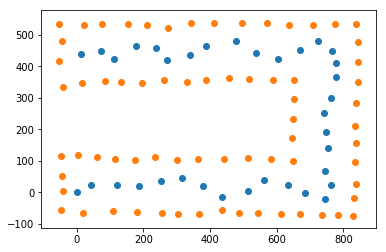

In [22]:
plt.scatter(xr,yr)
plt.scatter(xb,yb)
plt.show()

# Subtask 3

In [221]:
mat_contents = sio.loadmat('task3.mat')
beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']
print(beacons.shape,robots.shape,x.shape,y.shape)

(460, 1) (460, 1) (460, 1) (460, 1)


In [222]:
#as we need to pack all variables into big x array for solver, let's define lens of subparts:
len_xr = len(np.unique(robots))
len_yr = len_xr
len_ar = len_xr
len_xb = len(np.unique(beacons))
len_yb = len_xb
#this index arrays will be used to quick access for F function
robots_index = (robots-1).flatten().astype(np.int32)
beacons_index = (beacons-1).flatten().astype(np.int32)
x = x.flatten()
y = y.flatten()

In [223]:
#let's firstly apply previous tactics
xr_init,yr_init = correct_compass(beacons,robots,x,y)
x_init = np.concatenate((xr_init[:len_xr],yr_init[:len_yr],np.zeros((len_ar)),xr_init[len_xr:],yr_init[len_yr:]))

In [224]:
#use scipy.optimize.least_squares to calculate result
result = least_squares(F,x_init)
xr,yr,ar,xb,yb = unpackX(result['x'])

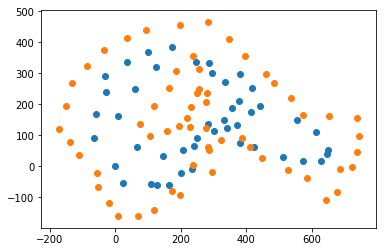

In [225]:
plt.scatter(xr,yr)
plt.scatter(xb,yb)
plt.show()

It doesn't look like a solution... As it was written in problem, in very few times robot make really huge mistake (misses the beacon number), so, let's choose loss function more tolerant to rare big errors.

In [44]:
%%time
result = least_squares(F,x_init,loss='cauchy')
xr,yr,ar,xb,yb = unpackX(result['x'])

CPU times: user 1min 26s, sys: 2min 4s, total: 3min 31s
Wall time: 1min 2s


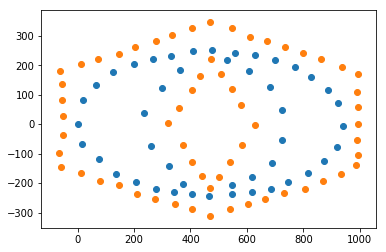

In [45]:
plt.scatter(xr,yr)
plt.scatter(xb,yb)
plt.show()

Looks better :)

In [46]:
%%time
result = least_squares(F,x_init,jac=jac,loss='cauchy')
xr,yr,ar,xb,yb = unpackX(result['x'])

CPU times: user 55.9 s, sys: 1min 2s, total: 1min 58s
Wall time: 34.2 s


Now we cutted time twice with analitical jacobian compared to 2-points method

In [47]:
%%time
result = least_squares(F,x_init,jac=jac,loss='huber')
xr,yr,ar,xb,yb = unpackX(result['x'])

CPU times: user 39.7 s, sys: 50.5 s, total: 1min 30s
Wall time: 26.7 s


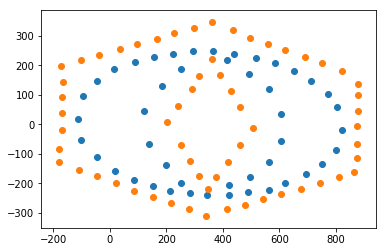

In [48]:
plt.scatter(xr,yr)
plt.scatter(xb,yb)
plt.show()

To use scipy.minimize with method='BFGS' we have to provide $fun(X) = \frac{1}{2} \sum_k loss\left( F_k(X)^2 \right) $ and $\nabla fun(X)$.

Assuming cauchi loss-function from scipy.optimize.least_squares $loss(z) = \ln \left( 1 + z \right)$:
$$
\nabla fun(X) = \frac{1}{2} \nabla \sum_k \ln \left(1 + F_k(X)^2 \right) = \frac{1}{2} \sum_k \nabla \ln \left( 1 + F_k(X)^2 \right) = \\
\frac{1}{2} \sum_k \frac{1}{1+F_k(X)^2} \cdot 2 F_k(X) \cdot \nabla F_k(X) = \\
\sum_k \frac{F_k(X)}{1+F_k(X)^2} J_k(x) \\
$$

In [226]:
def loss(X):
    return np.sum(np.log(1+F(X)**2))/2

def grad_loss(F_vec):
    return (F_vec/(1+F_vec**2))[np.newaxis,:]

def grad_fun(X):
    return grad_loss(F(X)).dot(jac(X)).flatten()

In [227]:
from scipy.optimize import minimize

In [230]:
%%time
result = minimize(loss, x_init, method='BFGS', jac=grad_fun,options={'disp':True})

         Current function value: 903.543121
         Iterations: 683
         Function evaluations: 770
         Gradient evaluations: 769
CPU times: user 9.54 s, sys: 9.74 s, total: 19.3 s
Wall time: 5.79 s


In [231]:
result.fun

903.5431208285868

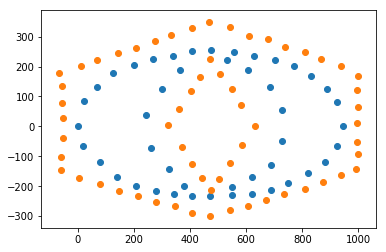

In [232]:
xr,yr,ar,xb,yb = unpackX(result['x'])
plt.scatter(xr,yr)
plt.scatter(xb,yb)
plt.show()

It works.
Now let's 'play with maxiter'. Run through list of maxiter up to 550 (almost 543) and compare result.fun with achieved previous result.

In [109]:
maxiter = list(range(0,600,50))
funs = np.zeros_like(maxiter)

In [110]:
funs = [minimize(loss, x_init, method='BFGS', jac=grad_fun,options={'maxiter':miter}).fun for miter in maxiter ]

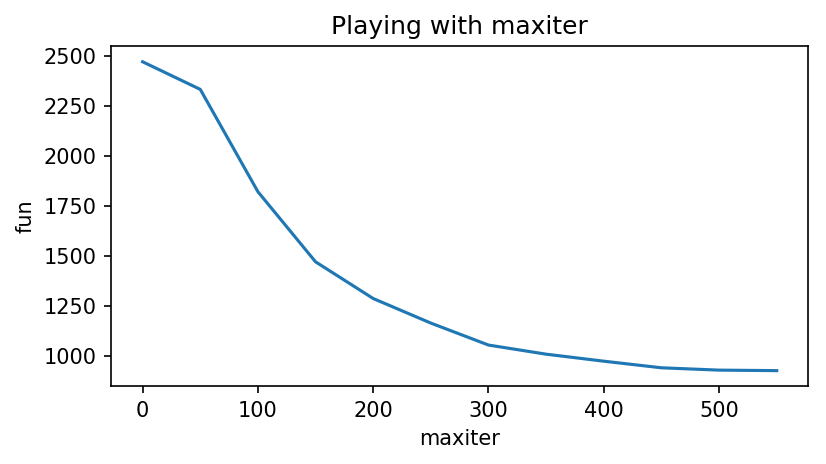

In [111]:
fig, ax = plt.subplots(figsize=(6,3),dpi=150)
ax.plot(maxiter, funs)
ax.set_xlabel('maxiter')
ax.set_ylabel('fun')
ax.set_title('Playing with maxiter');

Moving on - hessian!
$$\nabla \sum_k \frac{F_k(X)}{1+F_k(X)^2} J_k(X) = \\
\sum_k \nabla \frac{F_k(X)}{1+F_k(X)^2} J_k(X) = \\
\sum_k \nabla (\frac{F_k(X)}{1+F_k(X)^2}) J_k(X) +  \frac{F_k(X)}{1+F_k(X)^2} \cdot \nabla J_k(X) = \\
\sum_k \frac{1-F_k(X)^2}{(1+F_k(X)^2)^2} J_i(X) J_k(X) + \frac{F_k(X)}{1+F_k(X)^2} \cdot G_{ki}(X), \\
G_{ik}(X) = \frac{\partial J_k(X)}{\partial X_i}
$$

In [305]:
def sec_grad_loss(F_vec):
    return ((1-F_vec**2)/(1+F_vec**2)**2)[:,np.newaxis]
def fixed_sec_grad_loss(F_vec):
    return np.ones_like(sec_grad_loss(F_vec))

def other_grad_loss(x):
    return np.where((x > -1) * (x < 1), x, np.sign(x))[np.newaxis,:]

def other_loss(x):
    return np.sum(np.where((x > -1) * (x < 1), x ** 2 / 2, np.abs(x) - 1 / 2))

def other_sec_grad_loss(x):
    return np.where((x > -1) * (x < 1), 1, 1)[:,np.newaxis]

def other_grad_fun(X):
    return other_grad_loss(F(X)).dot(jac(X)).flatten()

def hess(X):
    #1st part:
    J = jac(X)
    F_vec = F(X)
    print(F_vec.shape)
    sgl = other_sec_grad_loss(F_vec)
    #print(sgl.shape)
    #np.matlib.repmat(sgl,1,J.shape[1])
    jac_jac = (sgl*J).transpose().dot(J)
    print(np.linalg.matrix_rank(J))
    #2nd part:
    gl = other_grad_loss(F_vec).flatten()
    #here we have !=0 only for angles (sin,cos)
    xr,yr,ar,xb,yb = unpackX(X)
    cos_a = np.cos(ar)
    sin_a = np.sin(ar)
    second_der = np.zeros((X.shape[0],X.shape[0]))
    with_x = x * np.cos(ar[robots_index]) - y * np.sin(ar[robots_index])
    with_y = x * np.sin(ar[robots_index]) + y * np.cos(ar[robots_index])
    #print(second_der.shape)
    #print(with_x.shape)
    #print(gl.shape)
    for i in range(x.shape[0]):
        second_der[len_xr*2+robots_index[i],len_xr*2+robots_index[i]] += gl[i]*with_x[i] + gl[i+x.shape[0]]*with_y[i]
    return jac_jac + second_der

In [306]:
%%time
result = minimize(other_loss, x_init, method='Newton-CG', jac=other_grad_fun, hess=hess, options={'disp':True,'xtol':1e-6})

(923,)
258
         Current function value: 50909.391361
         Iterations: 0
         Function evaluations: 26
         Gradient evaluations: 14
         Hessian evaluations: 1
CPU times: user 164 ms, sys: 296 ms, total: 460 ms
Wall time: 164 ms


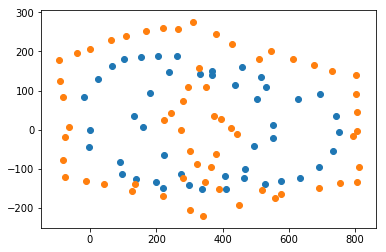

In [307]:
xr,yr,ar,xb,yb = unpackX(result['x'])
plt.scatter(xr,yr)
plt.scatter(xb,yb)
plt.show()

For the time of upload it doesn't work properly :( 
I'm working on it...

In [308]:
def linear_search(f, x, d, f0, g0, args):
    p = -d / np.sum(d ** 2) ** 0.5
    α = np.sum(d ** 2) ** 0.5
    print(f(x).shape,f0.shape,g0.shape,p.shape,α)
    while f(x + α * p, *args) > f0 + 0.5 * α * np.tensordot(g0, p, axes=1):
        α /= 2
    return x + p * α

def vanilla_Newton(f, X0, jac, hess, maxiter, args):
    J = jac(X0, *args)
    X = X0
    for k in range(maxiter):
        old_X = X
        d = np.tensordot(np.linalg.inv(hess(X, *args)),jac(X, *args),  axes=1)
        X = linear_search(f, X, d, f(X, *args), jac(X, *args), args)
        print(f(X))
    return X

In [309]:
%%time
X = vanilla_Newton(other_loss, x_init, other_grad_fun, hess, maxiter=600, args=())

(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() 

258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258

258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)
258
() () (258,) (258,) 34.002731455
50909.3913607
(923,)


KeyboardInterrupt: 

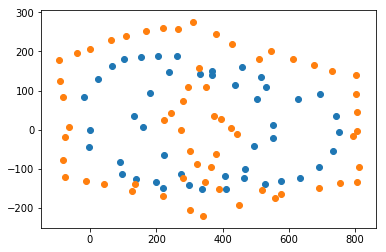

In [271]:
xr,yr,ar,xb,yb = unpackX(result['x'])
plt.scatter(xr,yr)
plt.scatter(xb,yb)
plt.show()

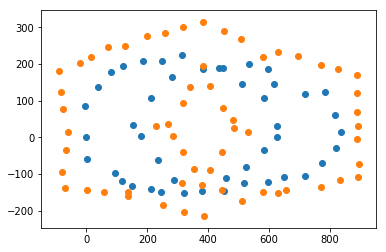

In [276]:
xr,yr,ar,xb,yb = unpackX(X)
plt.scatter(xr,yr)
plt.scatter(xb,yb)
plt.show()

In [290]:
len_xr

46